# Description

# Installing the required libraries (for MacOS)

In [20]:
!pip install tensorflow tensorflow-metal scikit-learn pandas matplotlib numpy plotly scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## For Windows, the following could be used for example


!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 scikit-learn pandas matplotlib numpy plotly scikeras

# Dataset

The dataset is downloaded from Yahoo as a csv.
For this project as of date March 1st 2024, I am choosing Berkshire Hathaway as it has gone under an stable growing trajectory and to analyse if from here there is more upside. 
Link: https://finance.yahoo.com/quote/BRK-B/history

In [2]:
import pandas as pd 
df = pd.read_csv('BRK-B.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-05-09,22.200001,24.400000,22.200001,23.200001,23.200001,4290000
1,1996-05-10,24.000000,24.200001,23.600000,24.000000,24.000000,1060000
2,1996-05-13,24.000000,24.100000,23.299999,23.900000,23.900000,700000
3,1996-05-14,24.000000,24.100000,23.100000,23.600000,23.600000,310000
4,1996-05-15,23.600000,23.700001,23.000000,23.200001,23.200001,545000
...,...,...,...,...,...,...,...
6995,2024-02-26,422.000000,430.000000,408.850006,409.140015,409.140015,7432300
6996,2024-02-27,409.209991,409.959991,401.709991,408.910004,408.910004,4609100
6997,2024-02-28,408.500000,414.670013,407.709991,412.140015,412.140015,4067400
6998,2024-02-29,413.100006,413.790009,408.380005,409.399994,409.399994,4845200


From the DataFrame, to simplify, I will just use date and market close price.

In [3]:
df = df[['Date','Close']]
df

,Date,Close
0,1996-05-09,23.200001
1,1996-05-10,24.000000
2,1996-05-13,23.900000
3,1996-05-14,23.600000
4,1996-05-15,23.200001
...,...,...
6995,2024-02-26,409.140015
6996,2024-02-27,408.910004
6997,2024-02-28,412.140015
6998,2024-02-29,409.399994


The date column is not a date tyoe as it can be seen:

In [4]:
df['Date']

0       1996-05-09
1       1996-05-10
2       1996-05-13
3       1996-05-14
4       1996-05-15
           ...    
6995    2024-02-26
6996    2024-02-27
6997    2024-02-28
6998    2024-02-29
6999    2024-03-01
Name: Date, Length: 7000, dtype: object

I want it to be a date. It can be converted to a date using datetime library.

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

# Test
datetime_object = str_to_datetime('2024-03-01	')
datetime_object

# Apply to all data in the date
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/var/folders/zs/3dtlfjsx5nl25g67z3ptd61c0000gn/T/ipykernel_20401/3247040408.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1996-05-09
1      1996-05-10
2      1996-05-13
3      1996-05-14
4      1996-05-15
          ...    
6995   2024-02-26
6996   2024-02-27
6997   2024-02-28
6998   2024-02-29
6999   2024-03-01
Name: Date, Length: 7000, dtype: datetime64[ns]

To get rid of the number indexing and using the date, which we now have as datetime type, df.pop can be used.

In [6]:
df.index = df.pop('Date')
df

,Close
Date,
1996-05-09,23.200001
1996-05-10,24.000000
1996-05-13,23.900000
1996-05-14,23.600000
1996-05-15,23.200001
...,...
2024-02-26,409.140015
2024-02-27,408.910004
2024-02-28,412.140015


## Plot of the stock

Text(0, 0.5, 'Stock price (USD)')

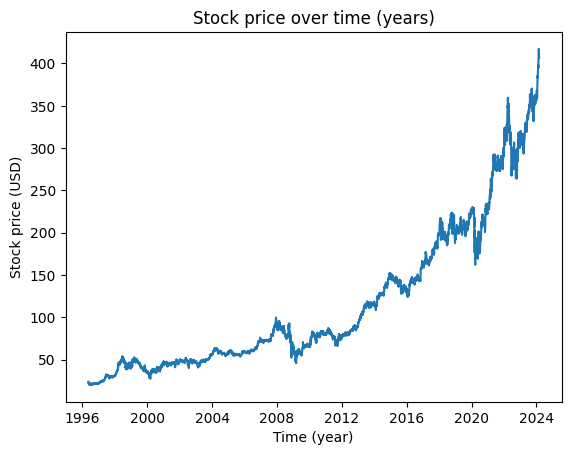

In [7]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])
plt.title("Stock price over time (years)")
plt.xlabel("Time (year)")
plt.ylabel("Stock price (USD)")

### Using Plotly library, we could make an interactive plot

Now, with the mouse over the line, we can see in detail the price and even the time at which the stock was priced in.

In [8]:
import plotly.express as px

fig = px.line(x=df.index, y=df['Close'], labels={'x':'Time (year)', 'y':'Stock price (USD)'}, title='Stock price over time (years)')
fig.show()

# Function

As this is a supervised learning problem, let's transform the dataset.

## Description

This function by default takes the closing price of a certain date as well as the two previous closing prices to see an correlation.

In [9]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2016-01-01'
windowed_df = df_to_windowed_df(df, 
                                '2016-01-01', 
                                '2024-03-01', 
                                n=2)
windowed_df

,Target Date,Target-2,Target-1,Target
0,2016-01-01,134.139999,133.259995,132.039993
1,2016-01-05,132.039993,130.750000,131.250000
2,2016-01-06,130.750000,131.250000,131.330002
3,2016-01-07,131.250000,131.330002,129.479996
4,2016-01-08,131.330002,129.479996,128.330002
...,...,...,...,...
2049,2024-02-26,415.160004,417.220001,409.140015
2050,2024-02-27,417.220001,409.140015,408.910004
2051,2024-02-28,409.140015,408.910004,412.140015
2052,2024-02-29,408.910004,412.140015,409.399994


# Dataset split

First the dataframe needs to  be converted into a numpy array to feed into the Tensorflow model.

In [10]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()  # Numpy array conversion
  
  dates = df_as_np[:, 0]  # just first columne is the date
  # a_matrix is a middle variable
  a_matrix = df_as_np[:, 1:-1]  # all the matrix except the last one, which is the prediction
  # reshape for model
  X = a_matrix.reshape((len(dates), a_matrix.shape[1], 1))
  # Now the labels 
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((2054,), (2054, 2, 1), (2054,))

Split = 80% training, 10% validation and 10% test

The split could also be done through sklearn.model_selection.train_test_split so the model does not get a section of the dataset, so it can get a bigger variety of data.

Text(0, 0.5, 'Stock price (USD)')

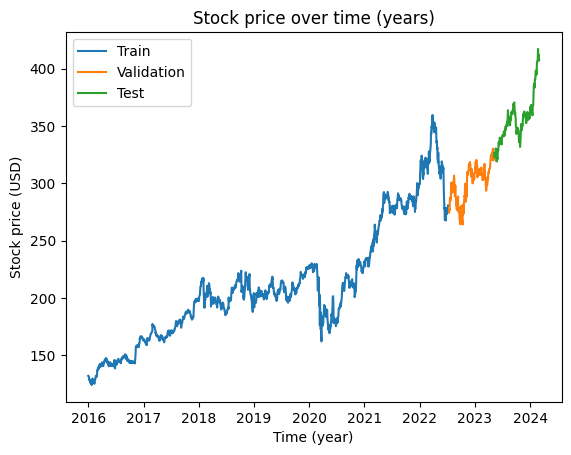

In [41]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.title("Stock price over time (years)")
plt.xlabel("Time (year)")
plt.ylabel("Stock price (USD)")

# Building the LSTM model

In [26]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the model building function
def model_tuning(neurons=64, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    if optimizer == 'adam':
        opt = Adam()
    elif optimizer == 'rmsprop':
        opt = RMSprop()
    
    model.compile(optimizer=opt, loss='mse', metrics=['mean_absolute_error'])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(model=model_tuning, verbose=0)

# Define the grid search parameters
# learning rate will be kept constant and default value of 0.001
param_grid = {
    'model__neurons': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.2, 0.3],
    'model__optimizer': ['adam', 'rmsprop'],
    'epochs': [50, 100]
}

# Setup and run the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Summary of the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

2024-03-03 12:46:52.939506: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-03-03 12:46:52.939530: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-03-03 12:46:52.939537: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-03-03 12:46:52.939560: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-03-03 12:46:52.939573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-03 12:46:52.939575: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-03-03 12:46:52.939578: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-03-03 12:46:52.939586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/r

Best: 0.891873 using {'epochs': 100, 'model__dropout_rate': 0.3, 'model__neurons': 64, 'model__optimizer': 'adam'}


In [35]:
# Best parameters
best_epoch = int(grid_result.best_params_['epochs'])
best_dropout_rate = int(grid_result.best_params_['model__dropout_rate'])
best_neuron_numbers = int(grid_result.best_params_['model__neurons'])
best_optimizer = grid_result.best_params_['model__optimizer']
if best_optimizer == 'adam':
        best_optimizer = Adam()
elif best_optimizer == 'rmsprop':
        best_optimizer = RMSprop()

model = Sequential([LSTM(best_neuron_numbers, input_shape=(X_train.shape[1], X_train.shape[2])),
                    Dropout(best_dropout_rate),
                    Dense(32, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(1)])

model.compile(loss='mse', 
              optimizer=best_optimizer,
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_epoch)

Epoch 1/100
52/52 [==============================] - 1s 15ms/step - loss: 44917.6875 - mean_absolute_error: 205.7308 - val_loss: 81425.6172 - val_mean_absolute_error: 284.9206
Epoch 2/100
52/52 [==============================] - 0s 9ms/step - loss: 29443.9238 - mean_absolute_error: 161.3684 - val_loss: 36893.6719 - val_mean_absolute_error: 191.4303
Epoch 3/100
52/52 [==============================] - 0s 9ms/step - loss: 4931.0474 - mean_absolute_error: 53.4875 - val_loss: 7537.7739 - val_mean_absolute_error: 85.3934
Epoch 4/100
52/52 [==============================] - 1s 11ms/step - loss: 2355.2278 - mean_absolute_error: 36.8412 - val_loss: 7127.7554 - val_mean_absolute_error: 83.1060
Epoch 5/100
52/52 [==============================] - 1s 11ms/step - loss: 995.7397 - mean_absolute_error: 19.5696 - val_loss: 1896.3599 - val_mean_absolute_error: 41.6040
Epoch 6/100
52/52 [==============================] - 1s 10ms/step - loss: 207.8694 - mean_absolute_error: 7.3504 - val_loss: 412.7989 -

## Prediction for training data

 1/52 [..............................] - ETA: 0s

52/52 [==============================] - 0s 4ms/step


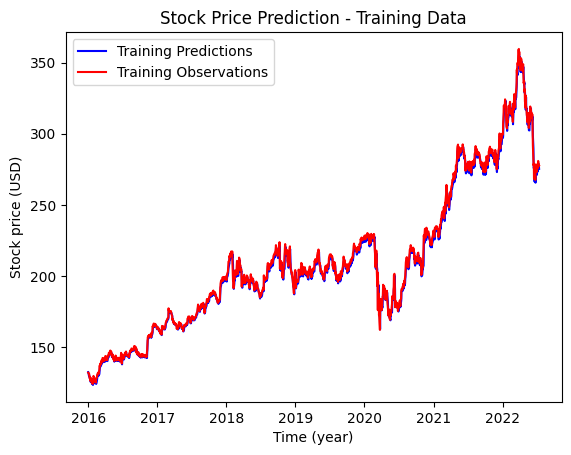

In [49]:
train_predictions = model.predict(X_train).flatten()

# Plotting with Matplotlib

plt.plot(dates_train, train_predictions, color = 'b')
plt.plot(dates_train, y_train, color = 'r')
plt.legend(['Training Predictions', 'Training Observations'])
plt.title("Stock Price Prediction - Training Data")
plt.xlabel("Time (year)")
plt.ylabel("Stock price (USD)")
plt.show()

# Plotting with Plotly

import plotly.graph_objects as go

# Create traces (lines) for the training predictions and training observations
trace1 = go.Scatter(x=dates_train, y=train_predictions, mode='lines', name='Training Predictions')
trace2 = go.Scatter(x=dates_train, y=y_train, mode='lines', name='Training Observations')

# Create a figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout with titles and axis labels
fig.update_layout(title='Stock Price Prediction - Training Data',
                  xaxis_title='Time (Year)',
                  yaxis_title='Stock Price (USD)',
                  legend_title='Legend')

# Show plot
fig.show()

## Prediction for validation data

7/7 [==============================] - 0s 4ms/step


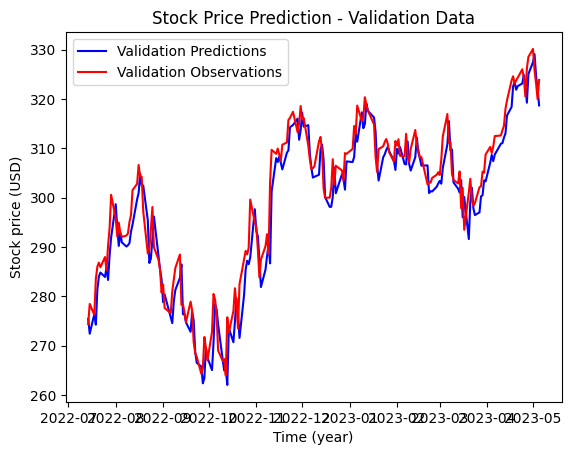

In [45]:
val_predictions = model.predict(X_val).flatten()

# Plotting with Matplotlib

plt.plot(dates_val, val_predictions, color = 'b')
plt.plot(dates_val, y_val, color = 'r')
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.title("Stock Price Prediction - Validation Data")
plt.xlabel("Time (year)")
plt.ylabel("Stock price (USD)")
plt.show()

# Plotting with Plotly

import plotly.graph_objects as go

# Create traces (lines) for the training predictions and training observations
trace1 = go.Scatter(x=dates_train, y=val_predictions, mode='lines', name='Validation Predictions')
trace2 = go.Scatter(x=dates_train, y=y_val, mode='lines', name='Validation Observations')

# Create a figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout with titles and axis labels
fig.update_layout(title='Stock Price Prediction - Validation Data',
                  xaxis_title='Time (Year)',
                  yaxis_title='Stock Price (USD)',
                  legend_title='Legend')

# Show plot
fig.show()

## Prediction for testing data

7/7 [==============================] - 0s 5ms/step


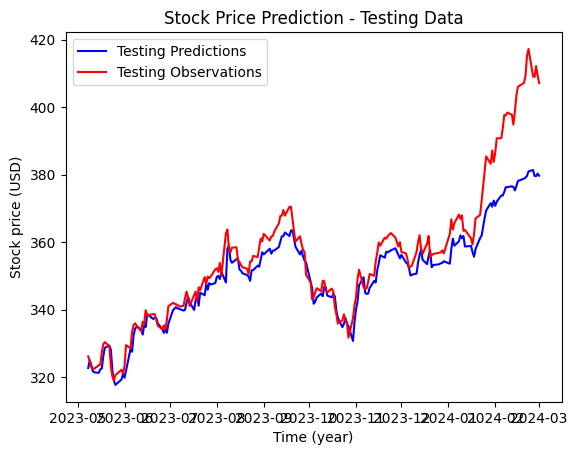

In [50]:
# Predict for testing data

test_predictions = model.predict(X_test).flatten()

# Plotting with Matplotlib

plt.plot(dates_test, test_predictions, color = 'b')
plt.plot(dates_test, y_test, color = 'r')
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.title("Stock Price Prediction - Testing Data")
plt.xlabel("Time (year)")
plt.ylabel("Stock price (USD)")
plt.show()

# Plotting with Plotly

import plotly.graph_objects as go

# Create traces (lines) for the training predictions and training observations
trace1 = go.Scatter(x=dates_test, y=test_predictions, mode='lines', name='Testing Predictions')
trace2 = go.Scatter(x=dates_test, y=y_test, mode='lines', name='ValiTestingdation Observations')

# Create a figure and add traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout with titles and axis labels
fig.update_layout(title='Stock Price Prediction - Testing Data',
                  xaxis_title='Time (Year)',
                  yaxis_title='Stock Price (USD)',
                  legend_title='Legend')

# Show plot
fig.show()

## All the data together

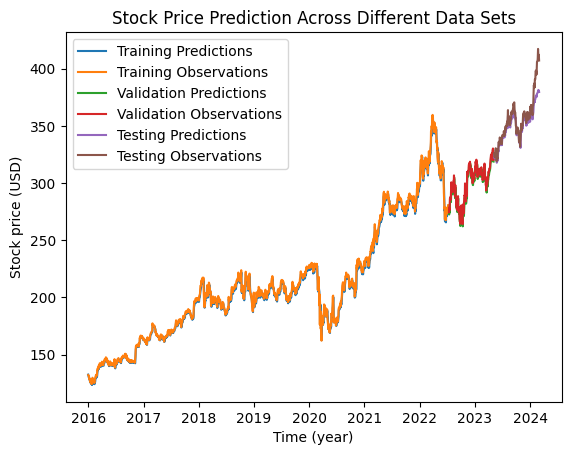

In [56]:
# Matplotlib

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
plt.title("Stock Price Prediction Across Different Data Sets")
plt.xlabel("Time (year)")
plt.ylabel("Stock price (USD)")
plt.show()

#Plotly

# Traces for each series
trace1 = go.Scatter(x=dates_train, y=train_predictions, mode='lines', name='Training Predictions')
trace2 = go.Scatter(x=dates_train, y=y_train, mode='lines', name='Training Observations')
trace3 = go.Scatter(x=dates_val, y=val_predictions, mode='lines', name='Validation Predictions')
trace4 = go.Scatter(x=dates_val, y=y_val, mode='lines', name='Validation Observations')
trace5 = go.Scatter(x=dates_test, y=test_predictions, mode='lines', name='Testing Predictions')
trace6 = go.Scatter(x=dates_test, y=y_test, mode='lines', name='Testing Observations')

# Figure and add all traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)
fig.add_trace(trace4)
fig.add_trace(trace5)
fig.add_trace(trace6)

# Layout with titles and axis labels
fig.update_layout(title='Stock Price Prediction Across Different Data Sets',
                  xaxis_title='Time',
                  yaxis_title='Stock Price (USD)',
                  legend_title='Data Set')

# Show plot
fig.show()

# To see if the model is valid for the future

In [17]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 11ms/step


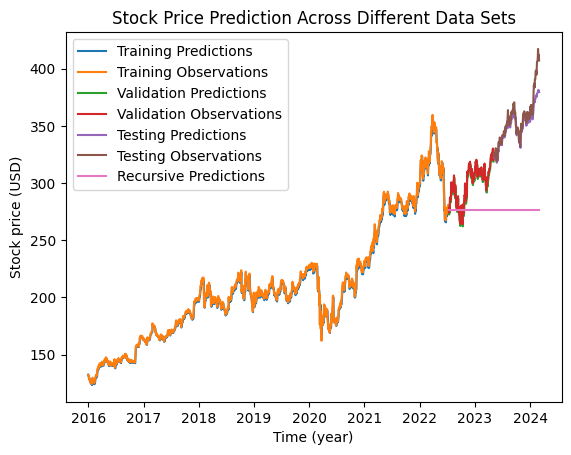

In [57]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])
plt.title("Stock Price Prediction Across Different Data Sets")
plt.xlabel("Time (year)")
plt.ylabel("Stock price (USD)")
plt.show()

It can be see that the model has no idea what the value will be, it just assumes it will be the same, thus, this model is valid for a span of couple a single day at most, at it needs the previous two days before as input.

# FUTURE WORK - TRY THE FOLLOWING TO SEE IF THERE IS IMPROVEMENT
Try different architectures such as:
- GRU (Gated Recurrent Unit)
- Convolutional Neural Networks (CNNs)
- Attention Mechanisms and Transformers